<a href="https://colab.research.google.com/github/laura-ayushi/Image-to-Speech-Recognition/blob/main/Image_to_speech_recognition_for_the_visually_impaired.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from google.colab import files
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tqdm.auto import tqdm
from tensorflow.keras import Sequential
from keras.layers import Dense, Activation
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 96 kB 3.6 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


#Loading the Dataset

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [4]:
upload =files.upload()
data = pd.read_csv("captions.csv")

Saving captions.csv to captions.csv


In [5]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

#Sequence length
SEQ_LENGTH = 12

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE

#Preparing the Dataset

In [7]:
#Text preprocessing has been done on the imagecaptions.csv file
def prepare(description):

      #Capitalizing the first word of each sentence of each caption
      description = description.capitalize()

      #Removing punctuations
      description = re.sub(r'[^\w\s]', '', description)

      #Removing extra spaces
      description = re.sub('\s+', ' ', description)
      description = description.strip()

      return description

In [8]:
# apply the text pre-processing on caption column
data['caption'] = data['caption'].apply(prepare)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


###Mapping captions to corresponding images

In [9]:
#Loads captions (text) data and maps them to corresponding images.
#filename: Path to the text file containing caption data.
#Returns:caption_mapping: Dictionary mapping image names and the corresponding captions
#text_data: List containing all the available captions


def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            #tokens = caption.strip().split()

            #if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
               # images_to_skip.add(img_name)
               # continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. The dataset is shuffled if need be
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training ,testing and validation sets
    train_size = int(len(caption_data) * train_size)
    test_size = int(len(caption_data) * 0.1)
    val_size = int(len(caption_data) * 0.1)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    testing_data = {
        img_name: caption_data[img_name] for img_name in all_images[:test_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[:val_size]
    }

    # 4. Return the splits
    return training_data, testing_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data,test_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ",len(train_data))
print("Number of testing samples: ",len(test_data))
print("Number of validation samples: ",len(valid_data))

Number of training samples:  6472
Number of testing samples:  809
Number of validation samples:  809


#Vectorizing Text Data

In [10]:
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize="lower_and_strip_punctuation",
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.2),layers.RandomContrast(0.3),])

In [11]:
# Let's test the `textvectorizer`
vectorization(['a child in a pink dress'])

<tf.Tensor: shape=(1, 12), dtype=int64, numpy=array([[  2,  43,   5,   2,  91, 171,   0,   0,   0,   0,   0,   0]])>

###Splitting the dataset into train and validation sets

In [12]:
def decode_and_resize(IMAGES_PATH):
    img = tf.io.read_file(IMAGES_PATH)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(IMAGES_PATH, captions):
    return decode_and_resize(IMAGES_PATH), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

#Building the Model

###Feature Extraction using CNN

In [13]:
def get_cnn_model():
    base_model = tf.keras.applications.InceptionV3(input_shape=(*IMAGE_SIZE, 3),include_top= False,weights='imagenet')
    #efficientnet.EfficientNetB0(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",)
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

#Feature Vectors

###Transformer Encoder and Decoder 

In [14]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 [==============================] - 1s 0us/step


#Training the Model

In [15]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
#early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
       super().__init__()
       self.post_warmup_learning_rate = post_warmup_learning_rate
       self.warmup_steps = warmup_steps

    def __call__(self, step):
      global_step = tf.cast(step, tf.float32)
      warmup_steps = tf.cast(self.warmup_steps, tf.float32)
      warmup_progress = global_step / warmup_steps
      warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
      return tf.cond(
        global_step < warmup_steps,
          lambda: warmup_learning_rate,
          lambda: self.post_warmup_learning_rate,
       )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

In [17]:
# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
)

Epoch 1/20
102/102 [==============================] - 85s 607ms/step - loss: 24.5285 - acc: 0.1859 - val_loss: 19.9342 - val_acc: 0.2993
Epoch 2/20
102/102 [==============================] - 55s 535ms/step - loss: 19.3923 - acc: 0.2995 - val_loss: 18.0825 - val_acc: 0.3289
Epoch 3/20
102/102 [==============================] - 54s 525ms/step - loss: 18.0561 - acc: 0.3248 - val_loss: 17.0062 - val_acc: 0.3462
Epoch 4/20
102/102 [==============================] - 54s 525ms/step - loss: 17.2172 - acc: 0.3371 - val_loss: 16.2702 - val_acc: 0.3583
Epoch 5/20
102/102 [==============================] - 54s 527ms/step - loss: 16.5812 - acc: 0.3482 - val_loss: 15.6814 - val_acc: 0.3687
Epoch 6/20
102/102 [==============================] - 55s 534ms/step - loss: 16.0226 - acc: 0.3574 - val_loss: 15.2486 - val_acc: 0.3726
Epoch 7/20
102/102 [==============================] - 55s 533ms/step - loss: 15.5361 - acc: 0.3653 - val_loss: 14.7098 - val_acc: 0.3864
Epoch 8/20
102/102 [=====================

#Making Predictions

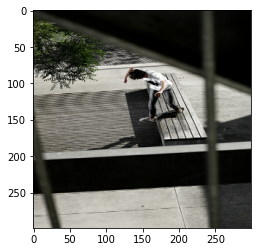

a boy does a skateboard trick on a wooden bench end


In [77]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


#def generate_caption():
# Select a random image from the validation dataset
sample_img = np.random.choice(valid_images)

# Read the image from the disk
sample_img = decode_and_resize(sample_img)
img = sample_img.numpy().clip(0, 255).astype(np.uint8)
plt.imshow(img)
plt.show()

# Pass the image to the CNN
img = tf.expand_dims(sample_img, 0)
img = caption_model.cnn_model(img)

# Pass the image features to the Transformer encoder
encoded_img = caption_model.encoder(img, training=False)

# Generate the caption using the Transformer decoder
decoded_caption = "<start> "
for i in range(max_decoded_sentence_length):
    tokenized_caption = vectorization([decoded_caption])[:, :-1]
    mask = tf.math.not_equal(tokenized_caption, 0)
    predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
    sampled_token_index = np.argmax(predictions[0, i, :])
    sampled_token = index_lookup[sampled_token_index]
    if sampled_token == " <end>":
        break
    decoded_caption += " " + sampled_token

decoded_caption = decoded_caption.replace("<start> ", "")
decoded_caption = decoded_caption.replace(" <end>", "").strip()

#Displays the decoded caption in a textual format
print(decoded_caption)

from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS(decoded_caption) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True) 

#Autoplay = True will play the sound automatically
#If you would not like to play the sound automatically, simply pass Autoplay = False.

# Check predictions for a few samples
#generate_caption()


##Testing the model in a web application

In [78]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 4.4 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 106 kB 81.1 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 84 kB 4.6 MB/s 
     |████████████████████████████████| 2.3 MB 63.0 MB/s 
     |████████████████████████████████| 278 kB 79.4 MB/s 
     |████████████████████████████████| 64 kB 3.5 MB/s 
     |████████████████████████████████| 80 kB 10.8 MB/s 
     |████████████████████████████████| 69 kB 7.8 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=fccb268f0c5e2991ff341b06703a3a9db2be58a09bf17635d69ac6c4cfa038ad
  Stored in direc

In [79]:
import gradio as gr

In [101]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(caption,audio):
# Upload an image to the user interface
  sample_img = gr.inputs.Image(type = "pil",label ="Original Image")

# Read the image from the disk
  sample_img = decode_and_resize(sample_img)
  img = sample_img.numpy().clip(0, 255).astype(np.uint8)
  plt.imshow(img)
  plt.show()

# Pass the image to the CNN
  img = tf.expand_dims(sample_img, 0)
  img = caption_model.cnn_model(img)

# Pass the image features to the Transformer encoder
  encoded_img = caption_model.encoder(img, training=False)

# Generate the caption using the Transformer decoder
  decoded_caption = "<start> "
  for i in range(max_decoded_sentence_length):
     tokenized_caption = vectorization([decoded_caption])[:, :-1]
     mask = tf.math.not_equal(tokenized_caption, 0)
     predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
     sampled_token_index = np.argmax(predictions[0, i, :])
     sampled_token = index_lookup[sampled_token_index]
     if sampled_token == " <end>":
      break

  decoded_caption += " " + sampled_token

  decoded_caption = decoded_caption.replace("<start> ", "")
  decoded_caption = decoded_caption.replace(" <end>", "").strip()
#Displays the decoded caption in a textual format
  caption = gr.outputs.Textbox(label = 'caption')
  caption = print(decoded_caption)
  tts = gTTS(decoded_caption) #Provide the string to convert to speech
  tts.save('1.wav') #save the string converted to speech as a .wav file
  sound_file = '1.wav'
  audio = gr.Audio(sound_file) 
  audio = Audio(sound_file, autoplay=True) 
  return caption,audio

In [103]:
inputs =[
    gr.inputs.Image(type = "pil",label ="Original Image")
]
outputs =[
    gr.outputs.Textbox(label = 'caption'),
    gr.Audio(sound_file)
]
title = "Upload an image"

gr.Interface(generate_caption,inputs,outputs).launch()

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:21: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/utils.py:796: UserWarning: Expected 2 arguments for function <function generate_caption at 0x7f2f1aaba160>, received 1.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/utils.py:800: UserWarning: Expected at least 2 arguments for function <function generate_caption at 0x7f2f1aaba160>, received 1.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>